In [5]:
import tensorflow.keras
tensorflow.keras.__version__

'2.1.6-tf'

# Нейронная передача стиля в Keras



TНейронная передача стиля заключается в применении стиля изображения-образца
к целевому изображению при сохранении содержимого этого целевого изображения. Пример передачи стиля изображен на рисунке. В данном контексте под стилем в основном подразумеваются текстуры, цветовая
палитра и визуальные шаблоны в различных пространственных масштабах, а под
содержимым — высокоуровневая макроструктура изображения. Например, синежелтые круговые мазки на рисунке соответствуют стилю (в качестве образца использована картина Винсента Ван Гога «Звездная ночь»), а здания на фотографии,сделанной фотографом Тюбингеном (Tübingen), — это содержимое.



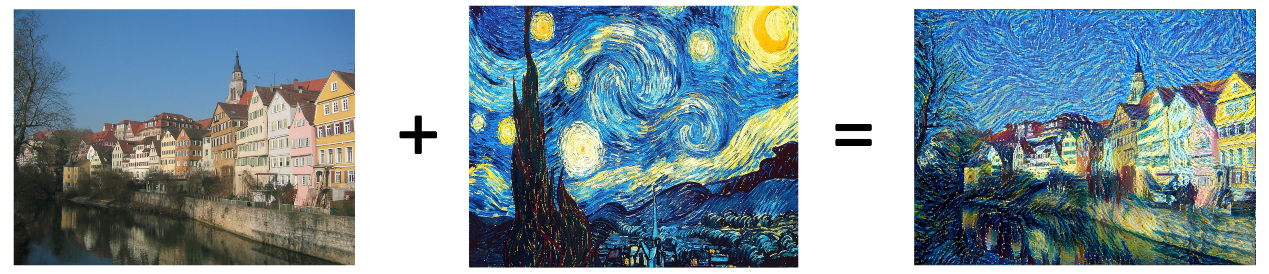

Идея передачи стиля, тесно связанная с созданием текстур, давно вынашивалась
в сообществе людей, увлеченных обработкой изображений, прежде чем воплотилась в алгоритм нейронной передачи стиля в 2015 году. Однако, как оказалось,
реализации передачи стиля, основанные на глубоком обучении, не имеют аналогов
среди прежних достижений, использовавших классические методики компьютерного зрения, и поэтому они породили удивительный бум в сфере художественных
приложений компьютерного зрения.
В основе реализации передачи стиля лежит та же идея, которая занимает центральное положение во всех алгоритмах глубокого обучения: вы задаете функцию
потерь, чтобы определить цель для достижения, и минимизируете ее. Вы знаете,
чего хотите: сохранить содержимое исходного изображения и передать стиль изображения-образца. Определив математически содержимое и стиль, соответствующую функцию потерь для минимизации можно обозначить так:


```
loss = distance(style(reference_image) - style(generated_image)) +
       distance(content(original_image) - content(generated_image))
```


Здесь distance — это функция нормы, такой как L2-норма, content — функция,
принимающая изображение и вычисляющая представление его содержимого,
а style — функция, принимающая изображение и вычисляющая представление его
стиля. Минимизация этой функции потерь приводит к тому, что style(generated_
image) приближается к style(reference_image), а content(generated_image) —
к content(original_image) , то есть достигается передача стиля, как мы ее определили.
Фундаментальное наблюдение, сделанное Гатисом с коллегами, заключается в том,
что глубокие сверточные нейронные сети дают возможность математически определить функции style и content. Посмотрим, как это происходит.


## Функция потерь содержимого

Как вы уже знаете, активации из нижних слоев в сети содержат локальную информацию об изображении, тогда как активации из верхних слоев содержат все более глобальную, абстрактную информацию. Другими словами, активации разных
слоев сверточной сети представляют собой разложение содержимого изображения в разных пространственных масштабах. Поэтому можно ожидать, что содержимое более глобального и абстрактного изображения будет захватываться представле-
ниями верхних слоев сети.
Соответственно, хорошим кандидатом на функцию потерь содержимого является L2-норма между активациями верхнего слоя в предварительно обученной сверточной сети, вычисленными по целевому изображению, и активациями того же
слоя, вычисленными по сгенерированному изображению. Это гарантирует, как
видно из верхнего слоя, что сгенерированное изображение будет выглядеть подобно оригинальному целевому изображению. Если допустить, что верхние слои сверточной сети действительно видят содержимое входных изображений, тогда
минимизация этой функции может рассматриваться как способ сохранения содержимого изображения.


## Функция потерь стиля

Функция потерь содержимого использует только один верхний слой, но функция
потерь стиля, согласно определению Гатиса и его коллег, использует несколько
слоев сверточной сети: ее цель — захватить внешний вид стиля изображения-об-
разца не в одном, а во всех пространственных масштабах, выделяемых сверточной
сетью. В качестве функции потерь стиля Гатис с коллегами используют матрицу
Грама активаций слоя: внутреннее произведение карт признаков данного слоя. Это
внутреннее произведение можно интерпретировать как матрицу корреляций между
признаками слоя. Корреляции фиксируют статистики шаблонов определенного
пространственного масштаба, которые эмпирически соответствуют текстурам,
обнаруженным в этом масштабе.
Следовательно, минимизация функции потерь стиля направлена на сохранение
сходных внутренних корреляций между активациями разных слоев изображе-
ния-образца и генерируемого изображения. Это, в свою очередь, гарантирует, что
текстуры, найденные в разных пространственных масштабах, будут выглядеть
одинаково в изображении-образце и сгенерированном изображении.


## В кратце

Проще говоря, предварительно обученную сверточную сеть можно использовать
для определения потерь и она будет
* сохранять содержимое, поддерживая сходство активаций верхнего слоя между
содержимым целевого и сгенерированного изображений. Сверточная сеть должна «видеть» оба изображения — целевое и сгенерированное — как содержащие одно и то же;
* сохранять стиль, поддерживая сходство корреляций в активациях всех, нижних
и верхних, слоев. Корреляции признаков захватывают текстуры: изображение-образец и сгенерированное изображение должны обладать одинаковыми текстурами в разных пространственных масштабах.
Теперь рассмотрим реализацию оригинального алгоритма нейронной передачи
стиля 2015 года с применением Keras. Как вы увидите далее, он имеет много общего
с реализацией DeepDream, представленной в предыдущем разделе.


## Нейронная передача стиля в Keras

Нейронную передачу стиля можно реализовать с использованием любой обученной
сверточной сети. Здесь мы используем сеть VGG19, которую использовали Гатис
с коллегами. VGG19 — это упрощенный вариант сети VGG16, представленной
в лекции 5, с тремя сверточными слоями.
Вот как выглядит весь процесс в общих чертах:
1. Настройка сети, которая вычисляет активации слоя VGG19 одновременно для
изображения-образца, целевого и сгенерированного изображений.
2. Активации, вычисленные по всем трем изображениям, используются для определения общей функции потерь, описанной выше, которая будет минимизироваться для достижения эффекта передачи стиля.
3. Настройка процедуры градиентного восхождения для минимизации этой функции потерь.
Сначала определим пути к изображению-образцу и целевому изображению. Чтобы
гарантировать совместимость размеров обрабатываемых изображений (сильно различающиеся размеры затрудняют передачу стиля), приведем их к общей высоте
в 400 пикселов.


In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# This is the path to the image you want to transform.
target_image_path = '/data/portrait.png'
# This is the path to the style image.
style_reference_image_path = '/data/cube.jpg'

# Dimensions of the generated picture.
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

Нам понадобится несколько вспомогательных функций для загрузки, а также для
предварительной и заключительной обработки изображений перед передачей изо-
бражений в сеть VGG19 и после вывода их из сети.


In [7]:
import numpy as np
from tensorflow.keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Настроим сеть VGG19. Она принимает на входе пакет из трех изображений: изо-
бражение с образцом стиля, целевое изображение и заготовка, куда будет помещено
сгенерированное изображение. Заготовка — это символический тензор, значениями
которого являются внешние массивы Numpy. Изображение-образец и целевое изо-
бражение являются статическими и поэтому определяются как K.constant, тогда
как значения в заготовке генерируемого изображения будут изменяться с течением
времени.

In [8]:
from tensorflow.keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# We build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')

Model loaded.


Теперь определим функцию потерь содержимого, которая позволит гарантировать
сходство представлений целевого и сгенерированного изображений в верхнем слое
сети VGG19.

In [32]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

Далее приводится функция потерь стиля. Она использует вспомогательную функ-
цию для вычисления матрицы Грама из входной матрицы: матрицы корреляций,
найденных в матрице оригинальных признаков.

In [10]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

К этим двум компонентам потерь добавляется третий: функция общей потери
вариации (total variation loss), которая оперирует пикселами генерируемого изображения. Она стимулирует пространственную целостность генерируемого изображения, что позволяет избежать появления мозаичного эффекта. Ее можно интерпретировать как регуляризацию потерь.


In [11]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

Функция потерь, которую мы должны минимизировать, возвращает среднее взве-
шенное этих трех компонентов. Для вычисления потери содержимого используется
только один верхний слой block5_conv2, а для вычисления потери содержимого
используется список слоев, включающий в себя нижние и верхние слои. Общая
потеря вариации добавляется в конец.
В зависимости от используемых изображений с целевым содержимым и образцом
стиля, может появиться желание настроить коэффициент content_weight (опре-
деляет вклад потерь содержимого в общую величину потерь). Большее значение
content_weight обеспечит большее сходство сгенерированного изображения с це-
левым.

In [28]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'block5_conv2'
# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 1e-6

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(style_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

Наконец, настроим процесс градиентного восхождения. В оригинальной статье
Гатиса оптимизация выполняется с использованием алгоритма L-BFGS, поэтому
мы тоже используем его здесь. 
Реализация алгоритма L-BFGS уже включена в пакет SciPy, однако она
имеет два незначительных ограничения:
* требует передачи значений функции потерь и градиентов в виде двух отдельных
* может применяться только к плоским векторам, тогда как у нас используется
трехмерный массив с изображением.
Было бы неэффективно вычислять значения потерь и градиентов независимо, пото-
му что это повлечет большой объем избыточных вычислений; процесс вычисления
замедлится почти вдвое по сравнению со случаем, когда эти величины вычисляются
вместе. Чтобы обойти эту проблему, определим класс Evaluator, вычисляющий
значения потерь и градиентов одновременно, который будет возвращать значение
потерь при первом обращении и кэшировать градиенты для повторного вызова.


In [33]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

Теперь можно запустить процесс градиентного восхождения с использованием
реализации алгоритма L-BFGS в SciPy, сохраняя текущее сгенерированное изо-
бражение после каждой итерации алгоритма (в данном случае одной итерации
соответствуют 20 шагов градиентного восхождения).

In [30]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'style_transfer_result'
iterations = 20

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 1633819500.0
Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 4s
Start of iteration 1


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 927647170.0
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 3s
Start of iteration 2
Current loss value: 673893250.0
Image saved as style_transfer_result_at_iteration_2.png
Iteration 2 completed in 3s
Start of iteration 3
Current loss value: 538754370.0
Image saved as style_transfer_result_at_iteration_3.png
Iteration 3 completed in 3s
Start of iteration 4
Current loss value: 448873660.0
Image saved as style_transfer_result_at_iteration_4.png
Iteration 4 completed in 3s
Start of iteration 5
Current loss value: 387479870.0
Image saved as style_transfer_result_at_iteration_5.png
Iteration 5 completed in 4s
Start of iteration 6
Current loss value: 340669920.0
Image saved as style_transfer_result_at_iteration_6.png
Iteration 6 completed in 4s
Start of iteration 7
Current loss value: 307690200.0
Image saved as style_transfer_result_at_iteration_7.png
Iteration 7 completed in 3s
Start of iteration 8
Current loss value: 280669060.0
Image sav

Далее показано, что получается в результате.

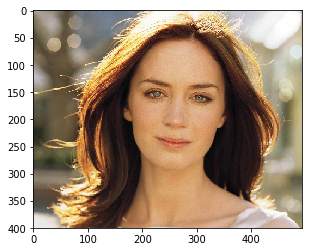

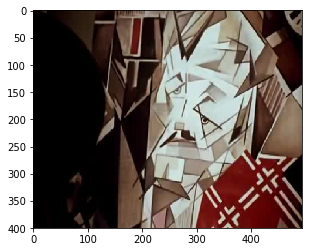

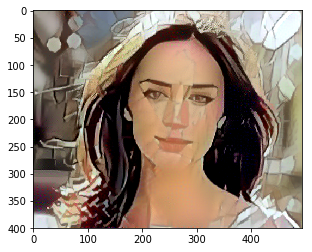

In [31]:
from matplotlib import pyplot as plt
%matplotlib inline
# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Generate image
plt.imshow(img)
plt.show()


Имейте в виду, что этот прием — лишь одна из форм ретекстурирования изображений, или передачи текстуры.
Лучшие результаты с его применением получаются, если изображения с образцами
стилей сильно текстурированы и самоподобны, а целевые изображения с содержимым не требуют различения мелких деталей, чтобы их можно было опознать.
Этот прием не наделен возможностями абстрагирования — с его помощью едва ли
получится перенести стиль с одного портрета в другой. Данный алгоритм ближе
к классической обработке сигналов, чем к ИИ, поэтому не нужно ожидать от него
чего-то сверхъестественного!
Кроме того, учтите, что этот алгоритм передачи стиля выполняется довольно медленно. Однако выполняемые преобразования достаточно просты, чтобы их можно было исследовать с использованием небольшой и быстрой сверточной сети при наличии достаточного объема обучающих данных. Быстрой передачи стиля можно
достичь, если сначала потратить много времени на создание входных/выходных
обучающих примеров для фиксированного изображения с образцом стиля, использовав метод, описанный здесь, а затем обучить простую сверточную сеть данному конкретному преобразованию стиля. После этого можно будет почти мгновенно.

## Задание

Сделайте потрет вашего любимого персонажа в стиле вашего любимого художника. 
Подберите параметры total_variation_weight, style_weight, content_weight, так чтобы результат выглядел максимально реалистично.
